In [1]:
from utils.apps import SimpleApp
from langchain_openai import ChatOpenAI
from utils.db import get_database_schema_execute_all
from utils.helper import save_results
import os
# from keys import OPENAI_KEY
from dotenv import load_dotenv
load_dotenv()

os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')

%load_ext autoreload
%autoreload 2

In [3]:
import glob
import shutil
import os

In [4]:
for path in glob.glob("./testDBs/*/new_results", recursive=True):
    if os.path.isdir(path):
        shutil.rmtree(path)

In [ ]:
# Collect all dbs and all prompts
db_list = [x for x in os.listdir('testDBs') if '.' not in x]
prompt_list = sorted([x for x in os.listdir('prompts') if x.endswith('.txt')])

print(db_list[0:])
print(prompt_list[0:])

# LLM model and parameters
llm_model = ChatOpenAI(model="gpt-4o", temperature=0)

# Explicit base prompts to ensure prompt-03 runs
base_prompts = [
    'prompt-01-baseline.txt',
    'prompt-02-persona.txt',
    'prompt-03-few-shot-example.txt',
    'prompt-04-chain-of-thought.txt',
    'prompt-05-tree-of-thought.txt',
    'prompt-06-processmining-knowledge.txt',
]

# Map db family to the correct prompt-07 file
prompt07_map = {
    'P2P': 'prompt-07-RunningExample.txt',
    'ERP': 'prompt-07-paperj.txt',
    'UWV': 'prompt-07-UWV.txt',
    'BPI2016': 'prompt-07-BPI2016.txt',
}

# Iterate over all dbs and prompt combinations
for db in db_list: # all dbs
# for db in db_list[0:3]: # BPI2016
# for db in db_list[3:6]: # ERP
# for db in db_list[8:9]: # P2P
# for db in db_list[9:12]: # UWV

    path_to_csv_files = 'testDBs/'+db+'/db/'
    path_to_csv_schema_file = 'testDBs/'+db+'/csv_schema.xlsx'
    path_to_groud_truth_eventlog = 'testDBs/'+db+'/ground-truth-eventlog.csv'
    db_output_dir = 'testDBs/'+db+'/example.db'
    result_output_dir = 'testDBs/'+db+'/best_new_results/'
    
    if not os.path.exists(result_output_dir):
        os.makedirs(result_output_dir)
    
    db_family = db.split('-')[0]
    try:
        db_schema = get_database_schema_execute_all(path_to_csv_files = path_to_csv_files,path_to_csv_schema_file=path_to_csv_schema_file, db_output_dir= db_output_dir)
    except Exception as e:
        print(f"Schema generation failed for {db}: {e}")
        continue

    # Choose db-specific prompt-07
    db_specific_prompt = prompt07_map.get(db_family)
    if db_specific_prompt not in prompt_list:
        print(f"{db_specific_prompt} not in the prompts directory; skipping db-specific prompt for {db}")
        selected_prompts = [p for p in base_prompts if p in prompt_list]
    else:
        selected_prompts = [p for p in base_prompts if p in prompt_list] + [db_specific_prompt]

    # Iterate over selected prompts
    for pr in selected_prompts:
        
        print('TESTCASE:',db, pr)

        file = open('prompts/'+pr, "r")
        file_txt = file.read()
        file.close()

        # Baseline prompt which is always part of the tested prompt
        prompt=(f"""Consider the following db schema: {db_schema}"""+file_txt
               +f"""Write one sql statement that returns an event log from the selected tables with the following columns: case_id, activity_id, timestamp. """
               +f"""Use quotes for identifiers."""
               +f"""Make sure that all columns of the eventlog are interpreted as varchar values."""               
               +f"""Return only the complete SQL query, leave out any other comments in the response. Return the query in plain text without markdown syntax.""")

        AgentState = {"messages": [prompt]}
        a = SimpleApp(path_to_db = db_output_dir, path_to_groud_truth_eventlog=path_to_groud_truth_eventlog, llm_model = llm_model)
        result = a.invoke(AgentState)
        save_results(chain_response=result, output_dir=result_output_dir, prompt_file=pr)

        try:
            print([result['result']])
        except Exception:
            print([f"""Can't calculate Precision, Recall and F1. ERROR in SQL"""])                  


['UWV-V31', 'BPI2016-V07', 'BPI2016-V31', 'UWV-V06', 'P2P-V63', 'ERP-V019', 'ERP-V209', 'P2P-V15', 'BPI2016-V24', 'UWV-V22', 'P2P-V03', 'ERP-V511']
['prompt-01-baseline.txt', 'prompt-02-persona.txt', 'prompt-03-few-shot-example.txt', 'prompt-04-chain-of-thought.txt', 'prompt-05-tree-of-thought.txt', 'prompt-06-processmining-knowledge.txt', 'prompt-07-BPI2016.txt', 'prompt-07-RunningExample.txt', 'prompt-07-UWV.txt', 'prompt-07-paperj.txt']
CREATE TABLE "T200" ("CaseID" TEXT, "EventDateTime" DATETIME, "EventID" TEXT, PRIMARY KEY ("CaseID", "EventDateTime", "EventID"))
CREATE TABLE "T400" ("CaseID" TEXT, "EventID_400" DATETIME, PRIMARY KEY ("CaseID", "EventID_400"))
CREATE TABLE "T100" ("CaseID" TEXT, "EventDateTime" DATETIME, "EventID" TEXT, "Attribute_101" TEXT, PRIMARY KEY ("CaseID", "EventDateTime", "EventID"))
CREATE TABLE "T300" ("CaseID" TEXT, "EventDate" TEXT, "EventID" TEXT, "Attribute_301" TEXT, PRIMARY KEY ("CaseID", "EventID"))
CREATE TABLE "T500" ("SessionID" TEXT, "CaseID" 

In [20]:
print(path_to_csv_files)
print(path_to_csv_schema_file)
print(db)
print(db_schema)

testDBs/ERP-V209/db/
testDBs/ERP-V209/csv_schema.xlsx
ERP-V209
TABLE customer:
CREATE TABLE "customer" ("id" TEXT, "name" TEXT, "address" TEXT, PRIMARY KEY ("id"));

TABLE order:
CREATE TABLE "order" ("id" TEXT, "creation_date" DATETIME, "customer" TEXT, PRIMARY KEY ("id"), FOREIGN KEY ("customer") REFERENCES "customer"("id"));

TABLE order_line:
CREATE TABLE "order_line" ("id" TEXT, "order" TEXT, "product" TEXT, "quantity" TEXT, "price" TEXT, PRIMARY KEY ("id"), FOREIGN KEY ("order") REFERENCES "order"("id"));

TABLE shipment:
CREATE TABLE "shipment" ("id" TEXT, "creation_date" DATETIME, "customer" TEXT, PRIMARY KEY ("id"), FOREIGN KEY ("customer") REFERENCES "customer"("id"));

TABLE shipment_line:
CREATE TABLE "shipment_line" ("id" TEXT, "shipment" TEXT, "order_line" TEXT, "quantity" TEXT, PRIMARY KEY ("id"), FOREIGN KEY ("shipment") REFERENCES "shipment"("id"), FOREIGN KEY ("order_line") REFERENCES "order_line"("id"));



In [23]:
db_list[6:]

['ERP-V209', 'P2P-V15', 'BPI2016-V24', 'UWV-V22', 'P2P-V03', 'ERP-V511']

In [22]:
db

'ERP-V209'

<Figure size 1200x600 with 0 Axes>

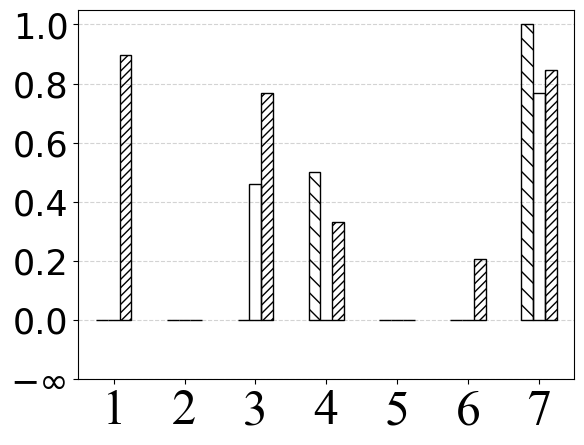

<Figure size 1200x600 with 0 Axes>

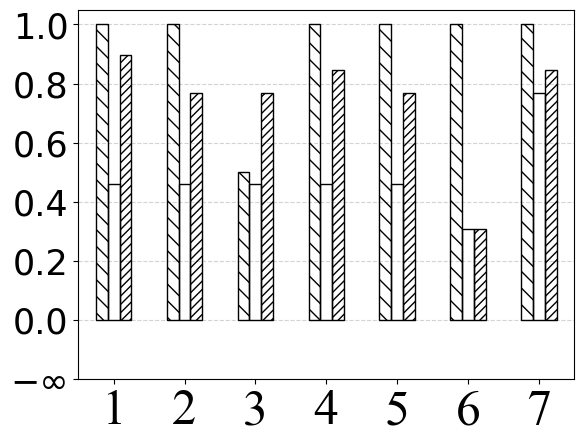

<Figure size 1200x600 with 0 Axes>

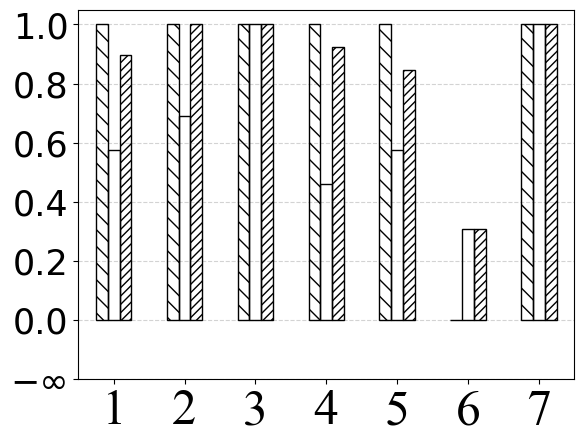

<Figure size 1200x600 with 0 Axes>

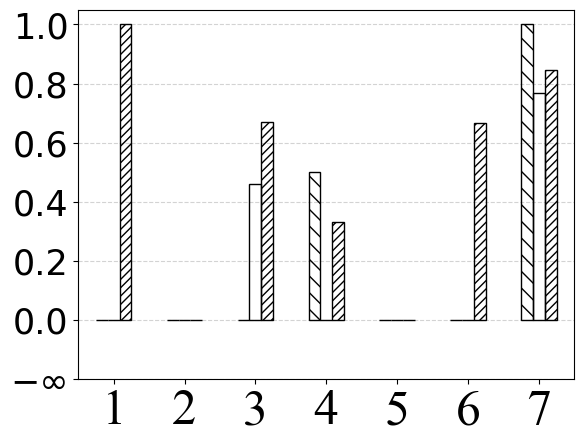

<Figure size 1200x600 with 0 Axes>

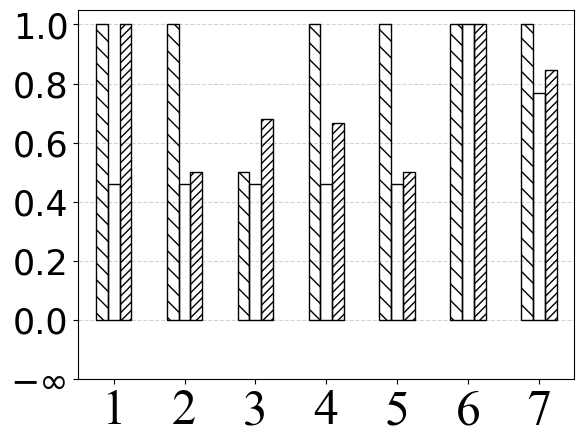

<Figure size 1200x600 with 0 Axes>

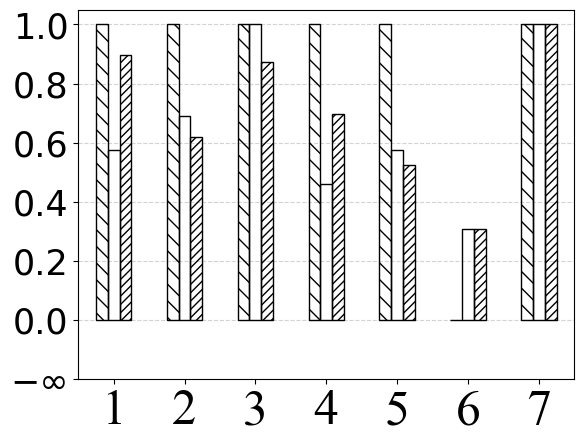

<Figure size 1200x600 with 0 Axes>

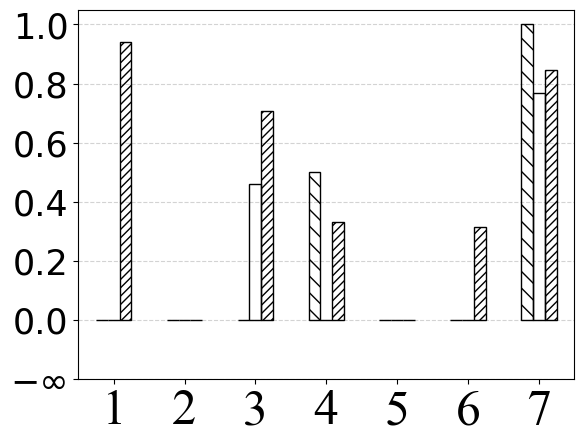

<Figure size 1200x600 with 0 Axes>

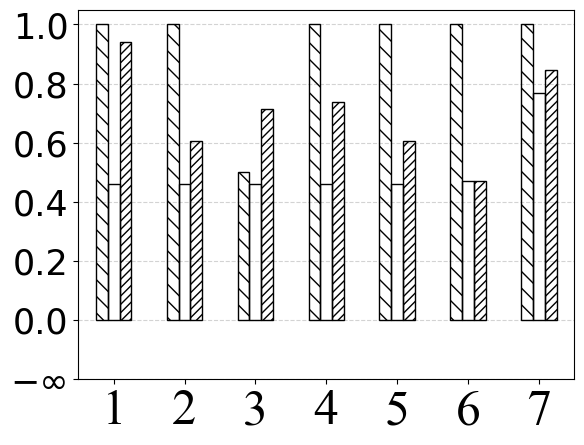

<Figure size 1200x600 with 0 Axes>

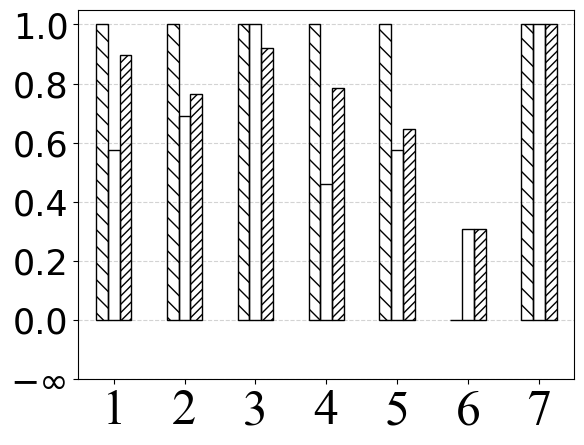

<Figure size 1200x600 with 0 Axes>

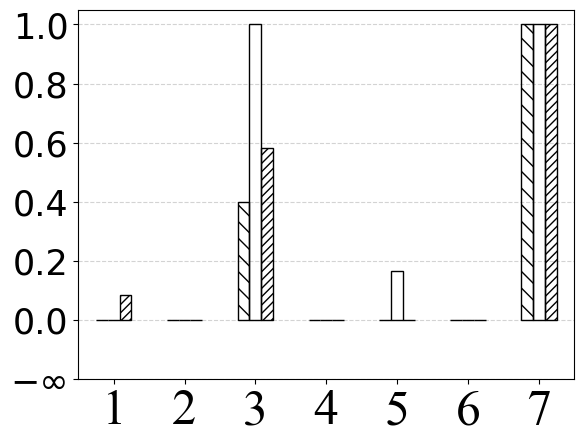

<Figure size 1200x600 with 0 Axes>

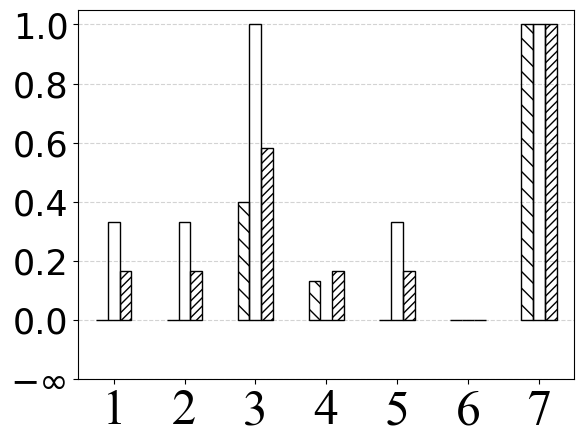

<Figure size 1200x600 with 0 Axes>

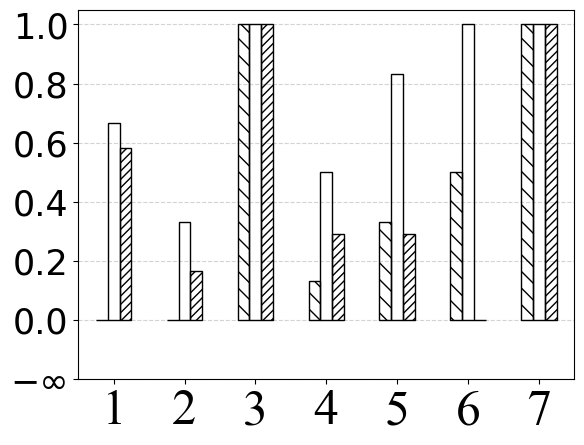

<Figure size 1200x600 with 0 Axes>

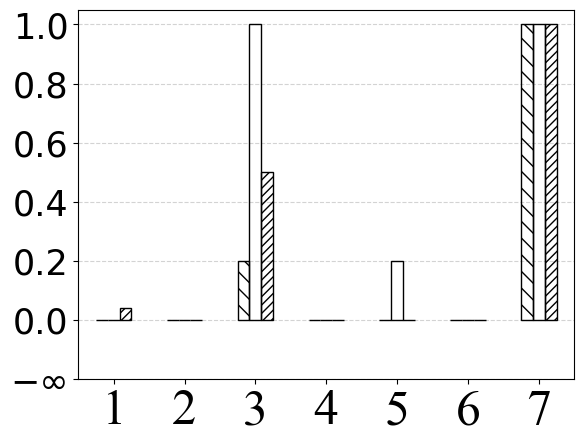

<Figure size 1200x600 with 0 Axes>

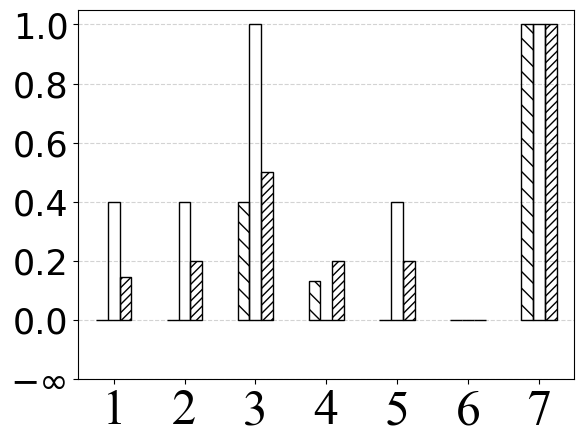

<Figure size 1200x600 with 0 Axes>

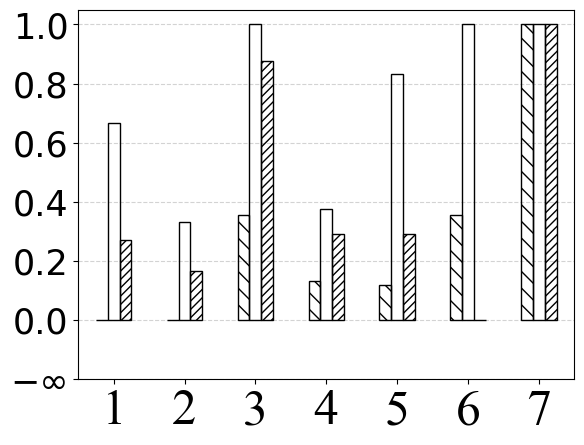

<Figure size 1200x600 with 0 Axes>

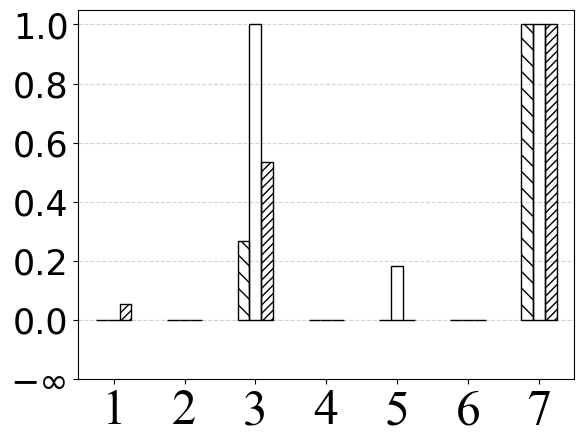

<Figure size 1200x600 with 0 Axes>

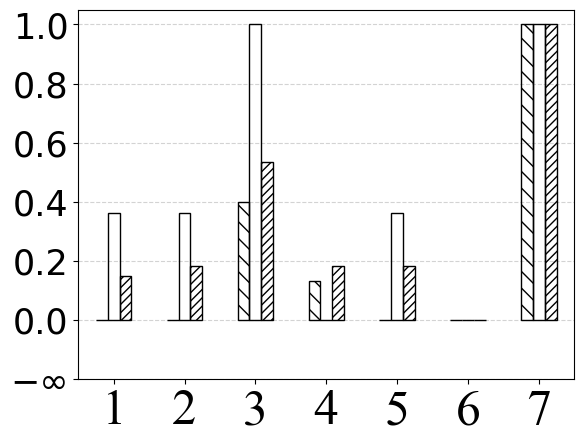

<Figure size 1200x600 with 0 Axes>

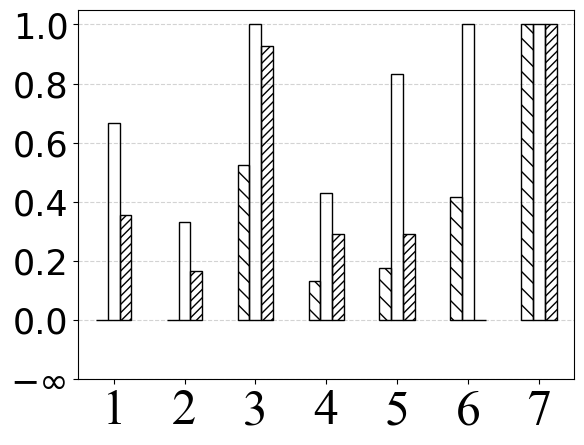

<Figure size 1200x600 with 0 Axes>

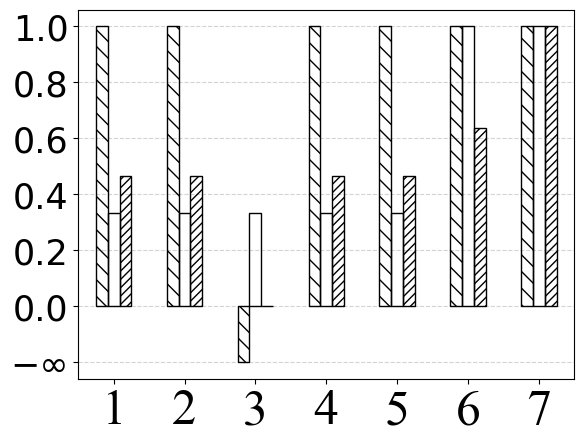

<Figure size 1200x600 with 0 Axes>

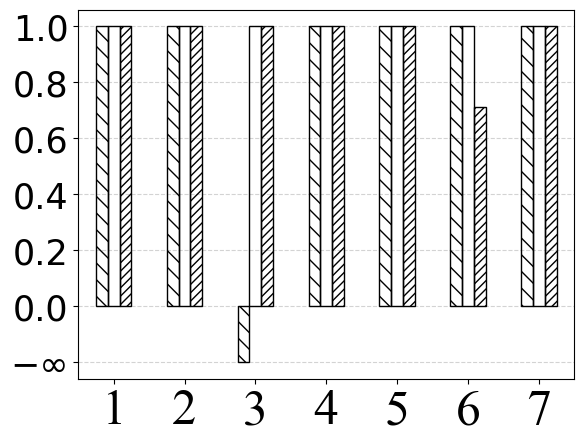

<Figure size 1200x600 with 0 Axes>

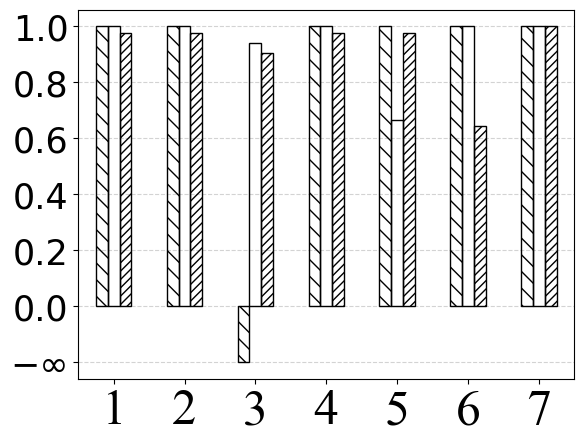

<Figure size 1200x600 with 0 Axes>

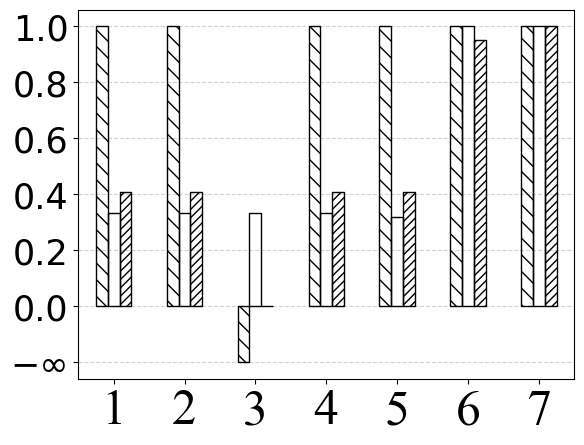

<Figure size 1200x600 with 0 Axes>

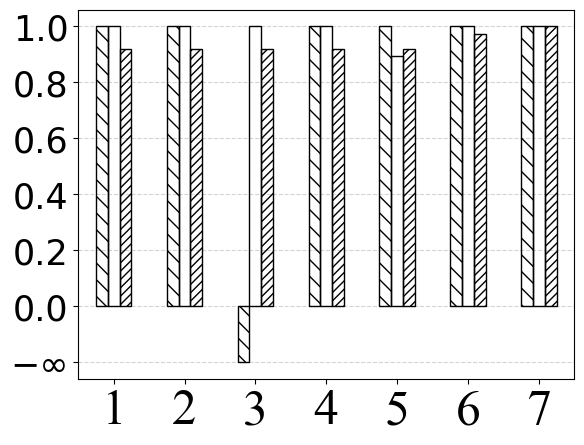

<Figure size 1200x600 with 0 Axes>

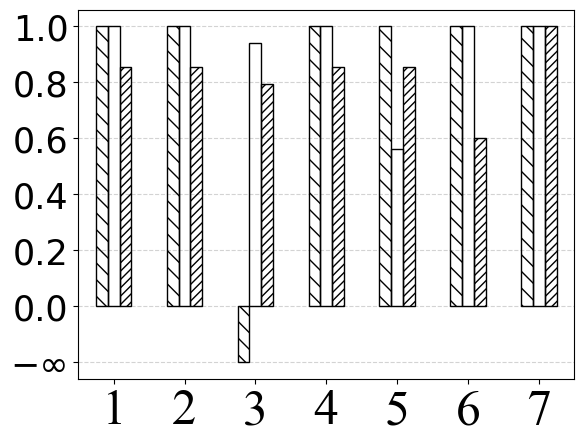

<Figure size 1200x600 with 0 Axes>

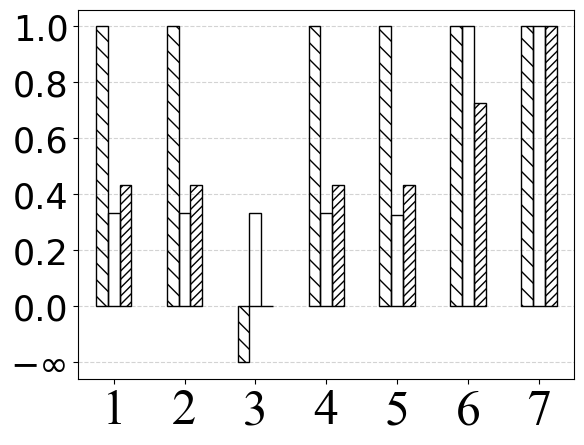

<Figure size 1200x600 with 0 Axes>

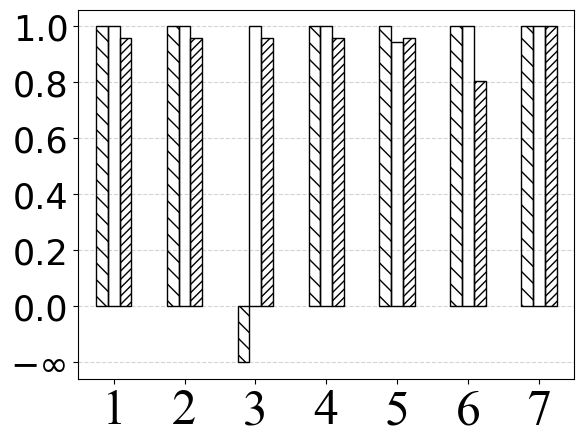

<Figure size 1200x600 with 0 Axes>

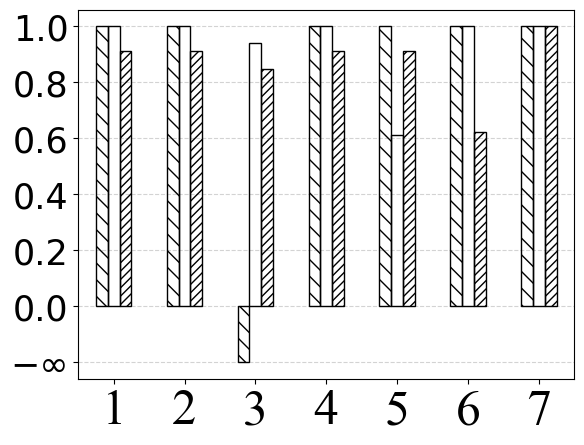

<Figure size 1200x600 with 0 Axes>

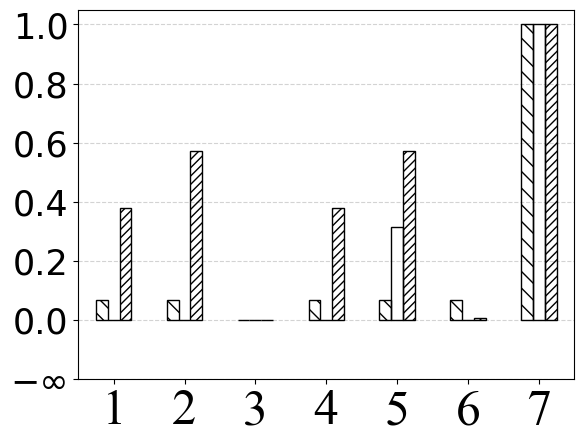

<Figure size 1200x600 with 0 Axes>

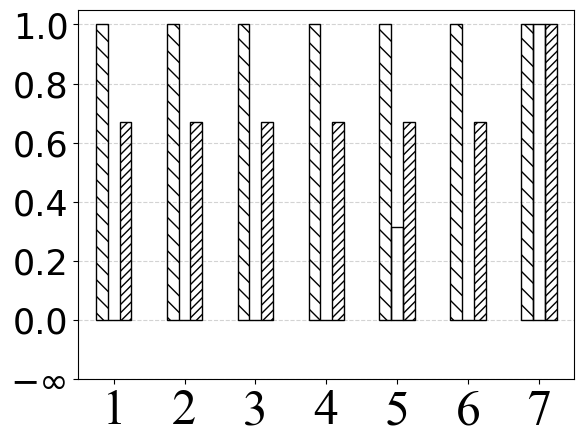

<Figure size 1200x600 with 0 Axes>

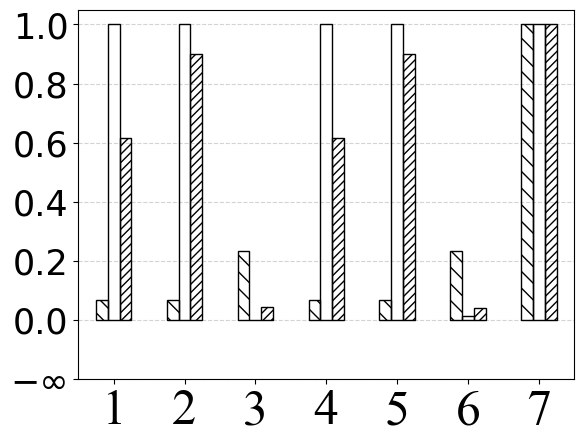

<Figure size 1200x600 with 0 Axes>

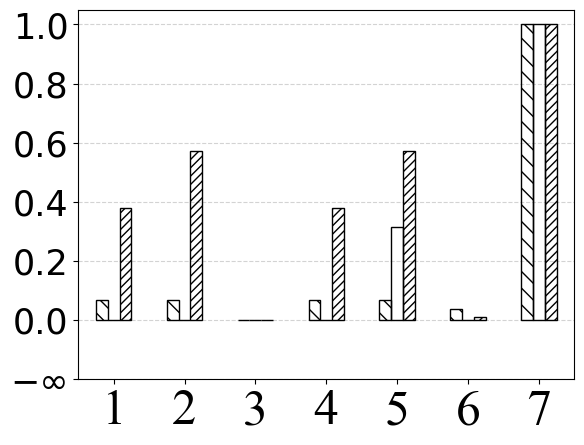

<Figure size 1200x600 with 0 Axes>

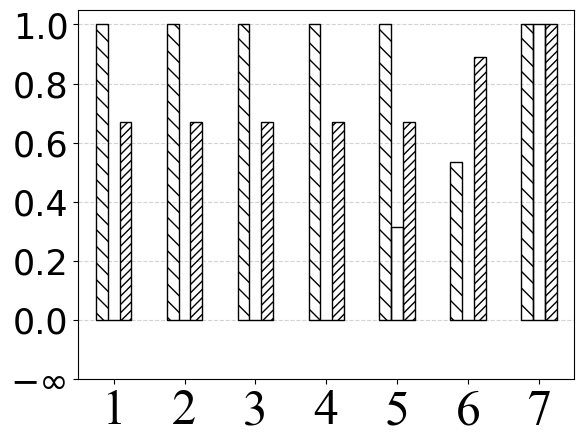

<Figure size 1200x600 with 0 Axes>

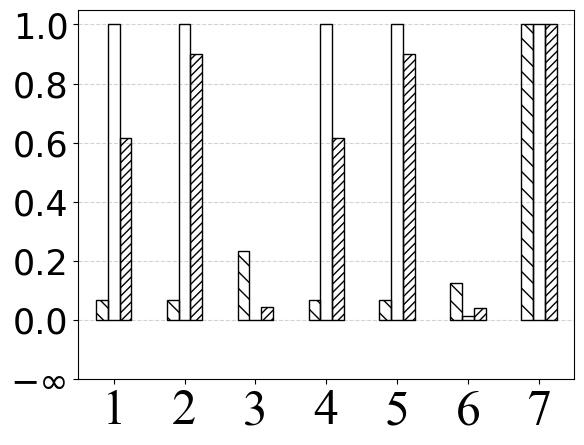

<Figure size 1200x600 with 0 Axes>

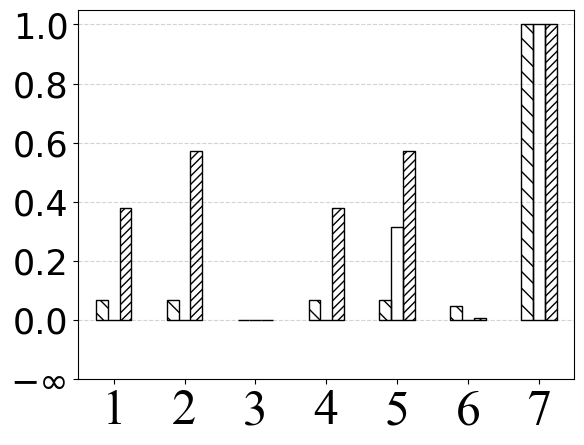

<Figure size 1200x600 with 0 Axes>

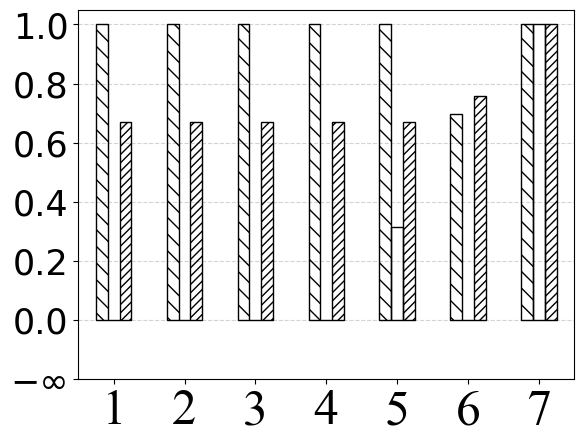

<Figure size 1200x600 with 0 Axes>

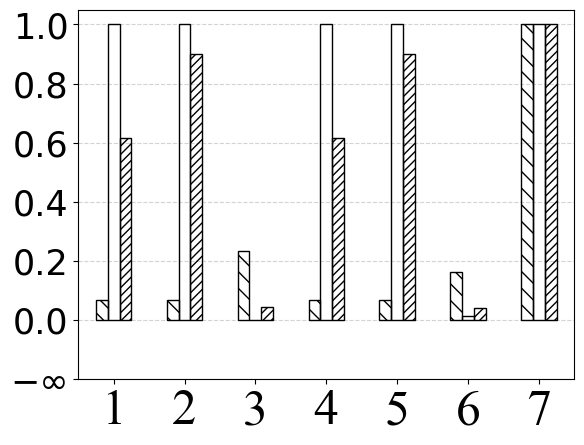

In [2]:
# Plot all result figures as pdf
from utils.plots import plot_parallel_coordinates

db_options = ['P2P', 'ERP', 'UWV', 'BPI2016']
metric_options = ['precision', 'recall', 'f1']
relaxed_options = ['', 'relaxed_','textual_']

path_to_dbs = 'testDBs/'

for db in db_options:
    for metric in metric_options:
        for relaxed in relaxed_options:
            plot_parallel_coordinates(path_to_dbs, db, metric, relaxed)

In [4]:
# Save the results as tables in csv format
from utils.plots import save_result_tables

db_options = ['P2P', 'ERP', 'UWV', 'BPI2016']
relaxed_options = ['', 'relaxed_','textual_']

path_to_dbs = 'testDBs/'

for db in db_options:
    for relaxed in relaxed_options:
        save_result_tables(path_to_dbs, db, relaxed)

Found 49 metric files (including errors) for P2P
Found 49 metric files (including errors) for P2P
Found 49 metric files (including errors) for P2P
Found 47 metric files (including errors) for ERP
Found 47 metric files (including errors) for ERP
Found 47 metric files (including errors) for ERP
Found 56 metric files (including errors) for UWV
Found 56 metric files (including errors) for UWV
Found 56 metric files (including errors) for UWV
Found 56 metric files (including errors) for BPI2016
Found 56 metric files (including errors) for BPI2016
Found 56 metric files (including errors) for BPI2016


In [8]:
import pandas as pd
df = pd.read_csv("/Users/nishantsushmakar/Documents/TUe/Seminar/event-log-extraction-for-process-mining/merged_f1_scores.csv")

In [9]:
df

,Dataset,Prompt,V1_f1,V1_relaxed_f1,V1_textual_f1,V2_f1,V2_relaxed_f1,V2_textual_f1,V3_f1,V3_relaxed_f1,V3_textual_f1
0,BPI2016,Prompt_1,0.067,1.000000,0.067000,0.0000,0.000,1.0000,0.380667,0.671000,0.614333
1,BPI2016,Prompt_2,0.067,1.000000,0.067000,0.0000,0.000,1.0000,0.571000,0.671000,0.900000
2,BPI2016,Prompt_3,0.000,1.000000,0.233000,0.0000,0.000,0.0000,0.000000,0.671000,0.043000
3,BPI2016,Prompt_4,0.067,1.000000,0.067000,0.0000,0.000,1.0000,0.380667,0.671000,0.614333
4,BPI2016,Prompt_5,0.067,1.000000,0.067000,0.3160,0.316,1.0000,0.571000,0.671000,0.900000
5,BPI2016,Prompt_6,0.047,0.698000,0.163000,0.0000,0.000,0.0140,0.008333,0.759000,0.042667
6,BPI2016,Prompt_7,1.000,1.000000,1.000000,1.0000,1.000,1.0000,1.000000,1.000000,1.000000
7,ERP,Prompt_1,0.000,0.000000,0.000000,0.0000,0.364,0.6670,0.055500,0.150000,0.356000
8,ERP,Prompt_2,0.000,0.000000,0.000000,0.0000,0.364,0.3330,0.000000,0.182000,0.167000
9,ERP,Prompt_3,0.267,0.400000,0.526000,1.0000,1.000,1.0000,0.535500,0.535500,0.928500
